In [ ]:
import gym
import os
import random
import time
import cv2
import copy
import numpy as np
import collections
import matplotlib.pyplot as plt
import json
import scipy
import argparse
from PIL import Image
from collections import deque
from tqdm import tqdm
import ray
from scipy.signal import savgol_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import torchvision as tv
from torch.utils.data import Dataset
import pickle

from src.common.atari_wrappers import wrap_deepmind, make_atari
from src.common.utils import LinearSchedule, DataLoaderX, DataPrefetcher, ReplayDataset
from src.common.vec_env import ShmemVecEnv, VecEnvWrapper, DummyVecEnv
from src.agents.model import NatureCNN

In [ ]:
game = "Breakout"

device = torch.device('cuda:0')
num_env = 8
num_actors = 32
num_gpus = torch.cuda.device_count()
num_cpus = mp.cpu_count()
total_steps = int(1e7)
epoches = 10
update_per_data = 8
replay_size = int(1e6)
exploration_ratio = 0.1
discount = 0.99
batch_size = 512
base_batch_size = 32
lr = 1e-3

target_net_update_freq = 250
exploration_ratio = 0.2
steps_per_epoch = total_steps // epoches 
replay = deque(maxlen=replay_size)



In [17]:
import torch
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [24]:
data = torch.load('ckpt/SpaceInvaders_e1000')

In [7]:
data.keys()

dict_keys(['model', 'optim', 'epoch', 'epsilon', 'steps', 'Rs', 'TRs', 'Qs', 'Ls'])

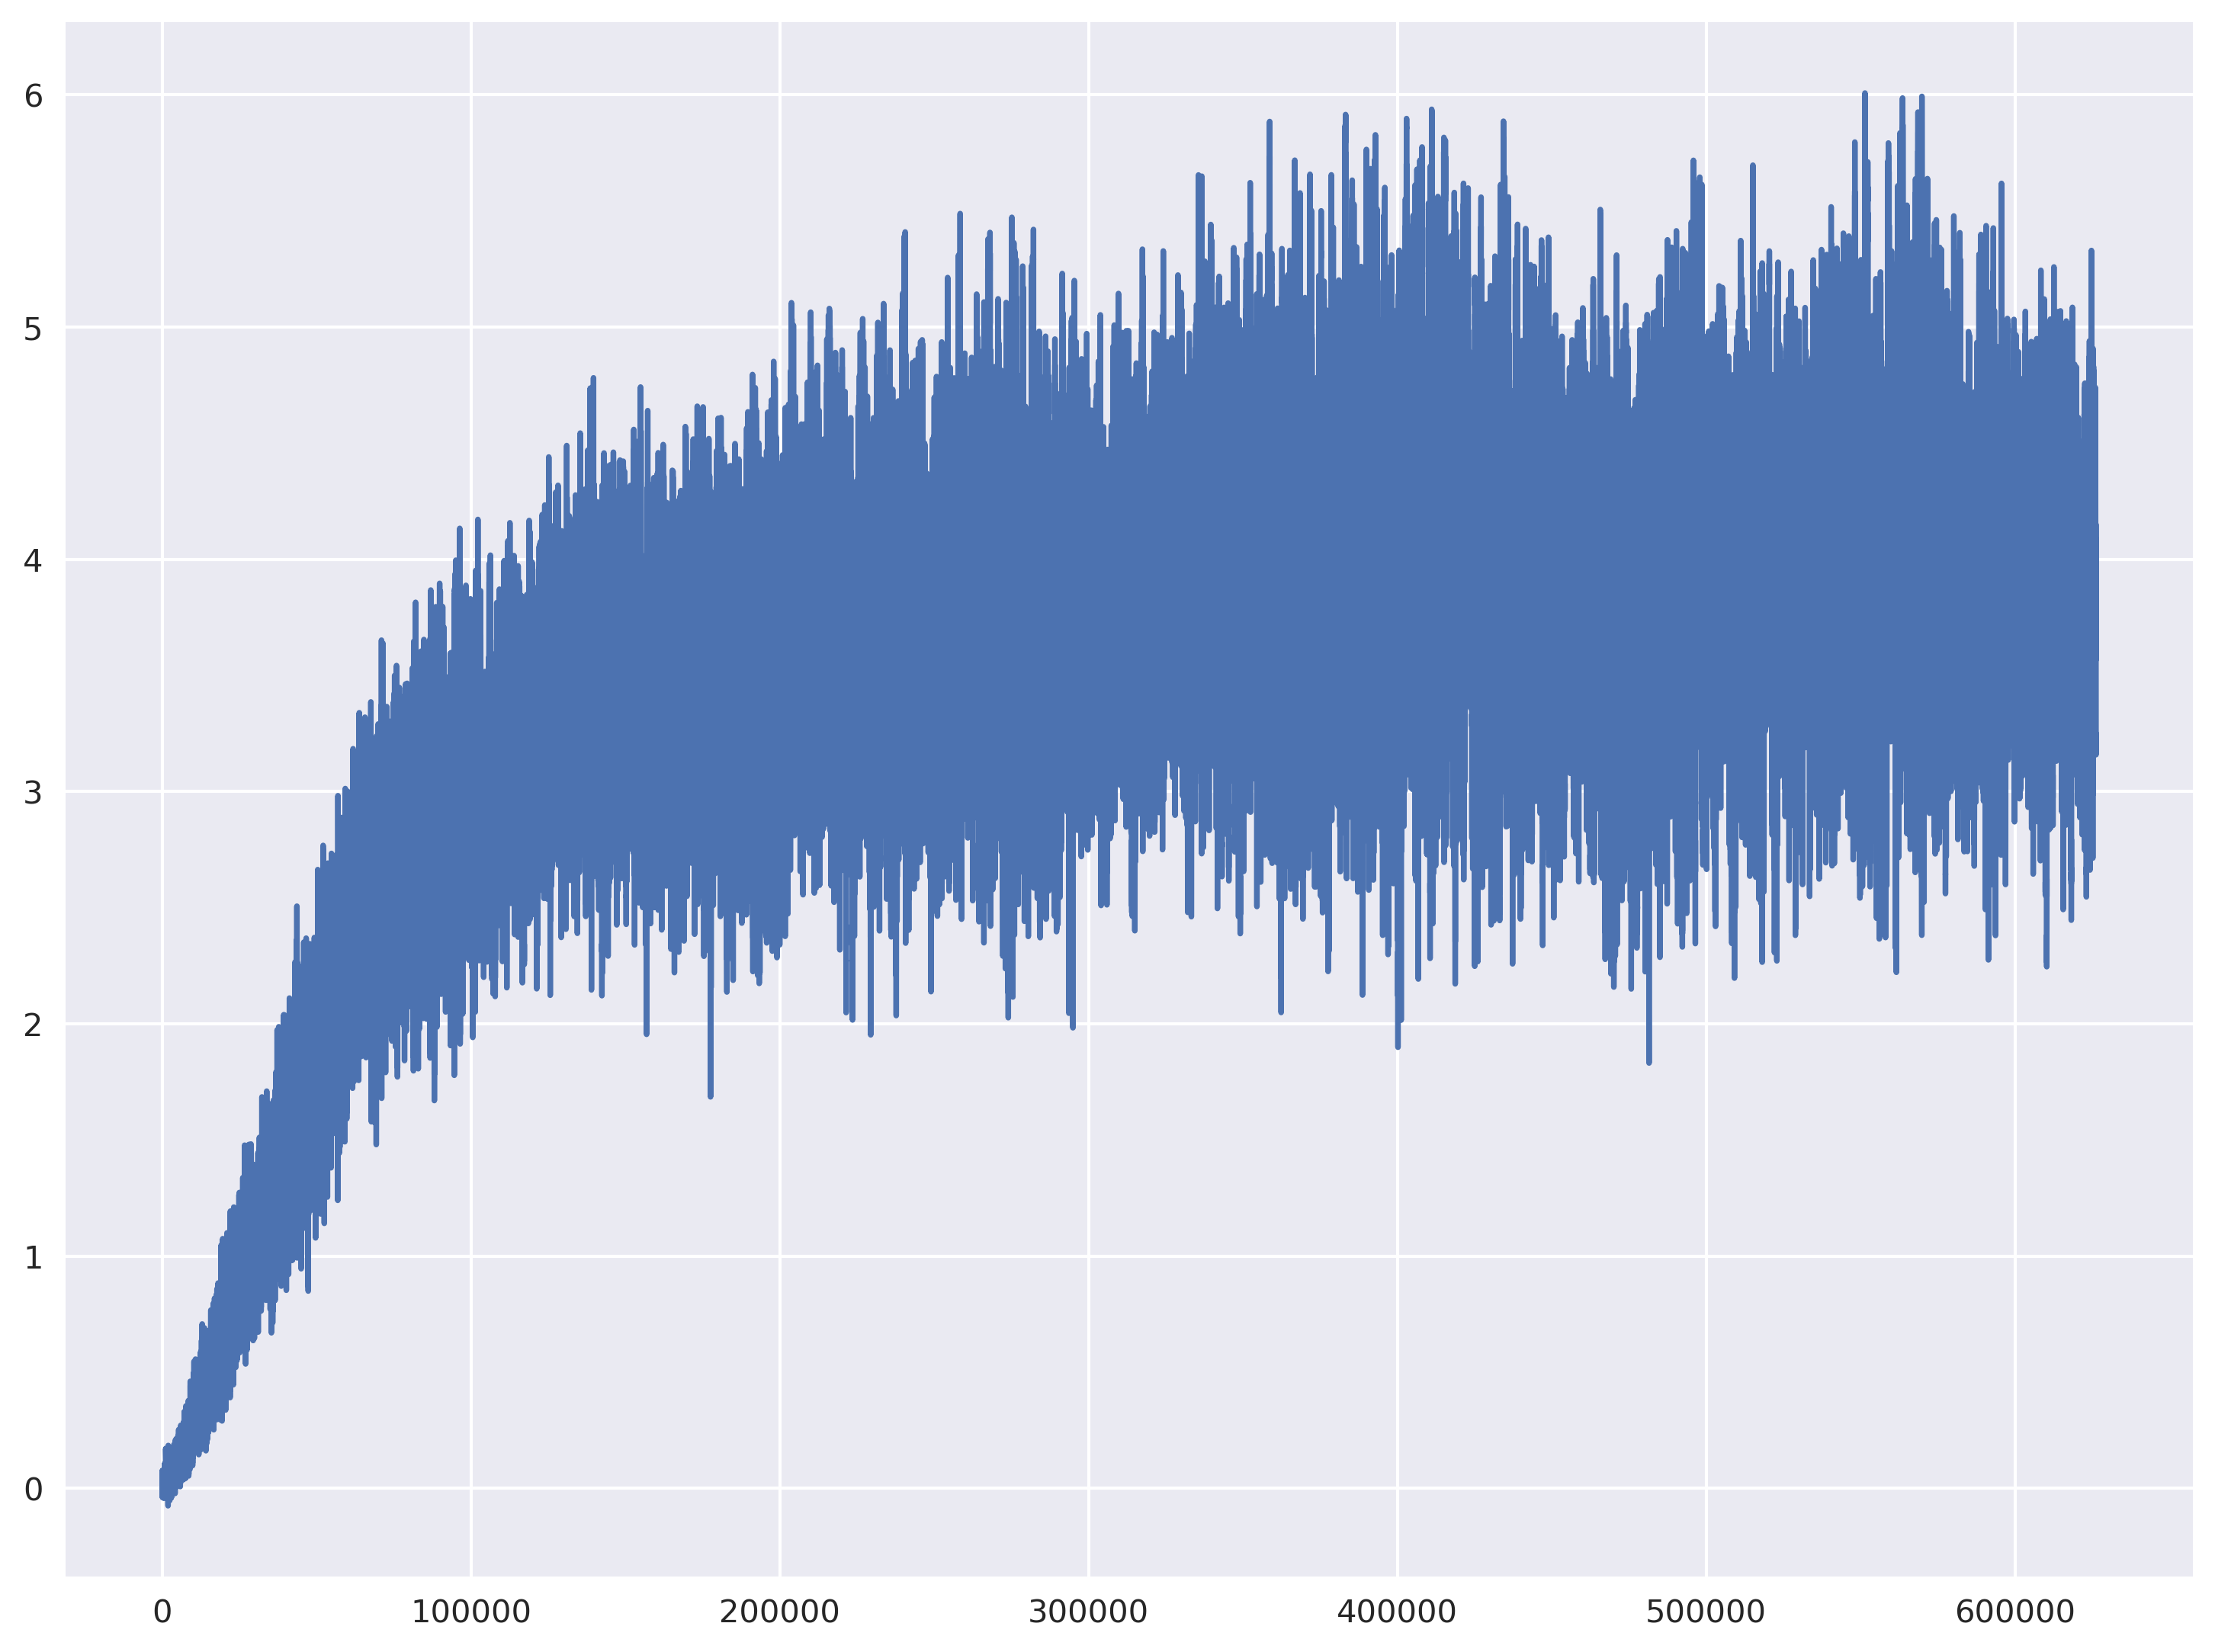

In [25]:
plt.figure(figsize=(12, 9), dpi=300)
plt.plot(data['Qs'][:])

In [11]:
plt.style.available

['seaborn-ticks',
 'classic',
 'seaborn-notebook',
 'seaborn-darkgrid',
 'grayscale',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'ggplot',
 'seaborn-dark',
 'seaborn-whitegrid',
 'seaborn-white',
 'dark_background',
 'seaborn-dark-palette',
 'seaborn-deep',
 'bmh',
 '_classic_test',
 'seaborn-paper',
 'seaborn',
 'seaborn-bright',
 'fivethirtyeight',
 'Solarize_Light2',
 'seaborn-muted',
 'fast',
 'seaborn-colorblind',
 'tableau-colorblind10',
 'muted',
 'no-latex',
 'high-vis',
 'retro',
 'ieee',
 'vibrant',
 'bright',
 'scatter',
 'pgf',
 'notebook',
 'grid',
 'science']